# Masking data using the `Fmask` cloud mask <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **[Sign up to the DEA Sandbox](https://app.sandbox.dea.ga.gov.au/)** to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[ga_ls8c_ard_3](https://explorer.dea.ga.gov.au/ga_ls8c_ard_3)

## Background
In the past, remote sensing researchers would reject partly cloud-affected scenes in favour of cloud-free scenes. 
However, multi-temporal analysis techniques increasingly make use of every quality assured pixel within a time series of observations. 
The capacity to automatically exclude low quality pixels (e.g. clouds, shadows or other invalid data) is essential for enabling these new remote sensing methods.

Analysis-ready satellite data from Digital Earth Australia includes pixel quality information that can be used to easily "mask" data (i.e. keep only certain pixels in an image) to obtain a time series containing only clear or cloud-free pixels.

## Description
In this notebook, we show how to mask Digital Earth Australia satellite data using boolean masks. The notebook demonstrates how to:

1. Load in a time series of satellite data including the `fmask` pixel quality band
2. Inspect the band's `flags_definition` attributes
3. Create clear and cloud-free masks and apply these to the satellite data
4. Buffer cloudy/shadowed pixels by dilating the masks by a specified number of pixels 
5. Clean cloudy/shadowed pixels to reduce false positive cloud detection
6. Mask out invalid nodata values and replace them with `nan`

***

## Getting started
First we import relevant packages and connect to the datacube. 
Then we define our example area of interest and load in a time series of satellite data.

In [1]:
import scipy.ndimage
import xarray
import numpy
import datacube
from datacube.utils.masking import make_mask
from datacube.utils.masking import mask_invalid_data
from odc.algo import mask_cleanup

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.plotting import rgb


### Connect to the datacube

In [2]:
dc = datacube.Datacube(app="Masking_data")

## Create a query and load satellite data

To demonstrate how to mask satellite data, we will load Landsat 8 surface reflectance RGB data along with a pixel quality classification band called `fmask`.

> **Note:** The `fmask` pixel quality band contains categorical data. 
When loading this kind of data, it is important to use a resampling method that does not alter the values of the input cells.
In the example below, we resample `fmask` data using the "nearest" method which preserves its original values. 
For all other bands with continuous values, we use "average" resampling.

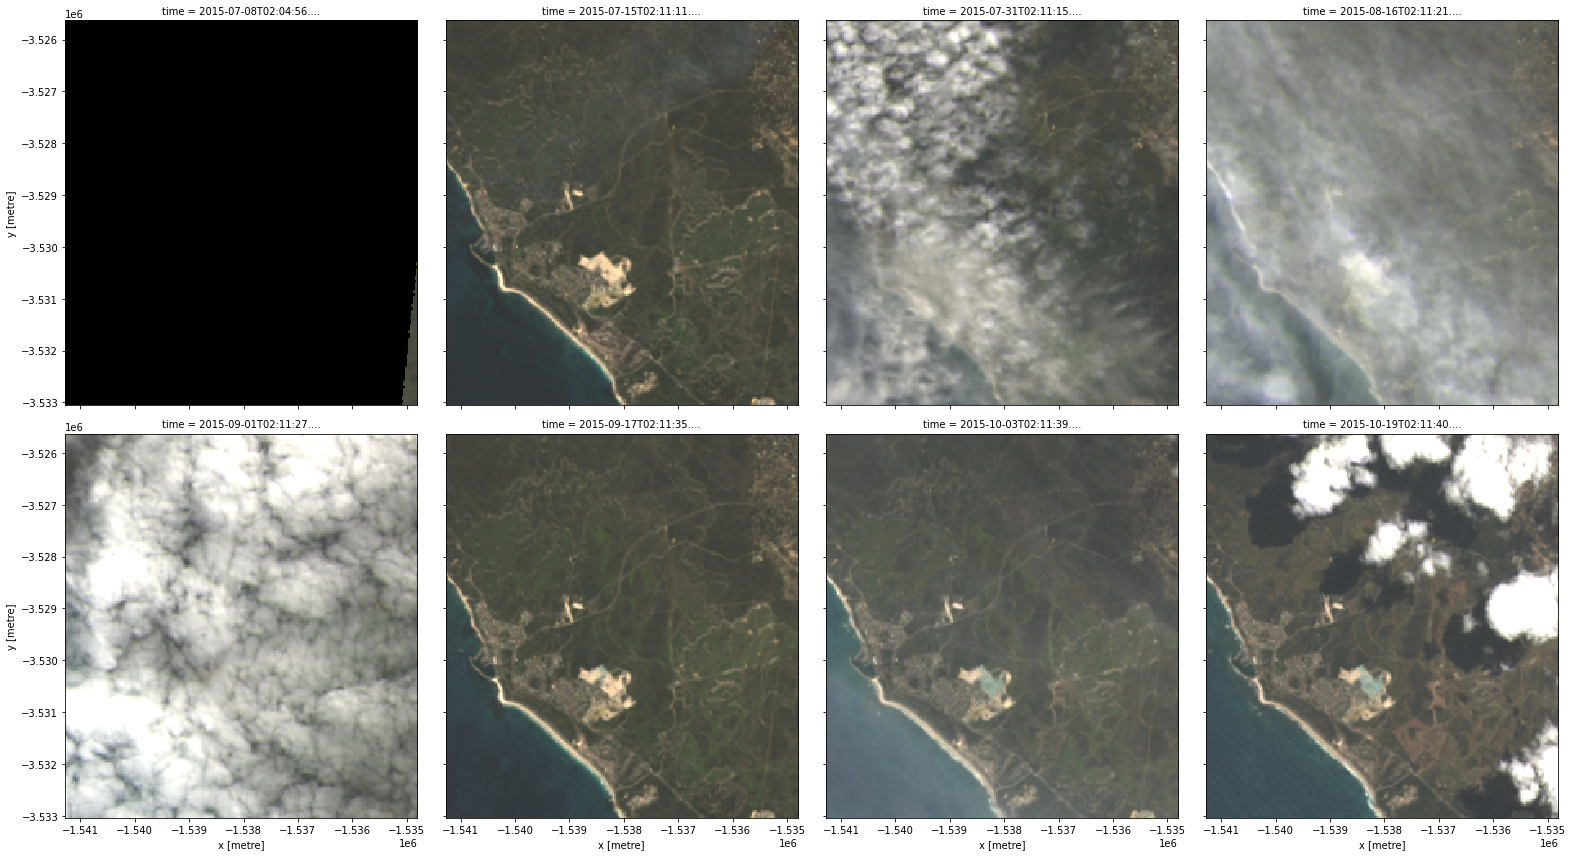

In [3]:
# Create a reusable query
y, x = -31.492482, 115.610186
radius = 0.03
query = {
    "x": (x - radius, x + radius),
    "y": (y - radius, y + radius),
    "time": ("2015-07", "2015-10")
}

# Load data from the Landsat 8 satellite
data = dc.load(product="ga_ls8c_ard_3",
               measurements=["nbart_blue", "nbart_green", "nbart_red", "fmask"],
               output_crs="EPSG:3577",
               resolution=[-30, 30],
               resampling={
                   "fmask": "nearest",
                   "*": "bilinear"
               },
               group_by='solar_day',
               **query)

# Plot the data
rgb(data, col="time")

These images show that our area of interest partially crosses the edge of the satellite track (e.g. the first panel), and therefore some areas in the image have no observed data. 
By inspecting our first timestep, we see that the `nodata` attribute reports the value -999, and that some of the pixels have that value:


In [4]:
data.nbart_red.isel(time=0)

<xarray.DataArray 'nbart_red' (y: 247, x: 216)>
array([[-999, -999, -999, ..., -999, -999, -999],
       [-999, -999, -999, ..., -999, -999, -999],
       [-999, -999, -999, ..., -999, -999, -999],
       ...,
       [-999, -999, -999, ...,  430,  420,  393],
       [-999, -999, -999, ...,  396,  388,  378],
       [-999, -999, -999, ...,  442,  396,  376]], dtype=int16)
Coordinates:
    time         datetime64[ns] 2015-07-08T02:04:56.777964
  * y            (y) float64 -3.526e+06 -3.526e+06 ... -3.533e+06 -3.533e+06
  * x            (x) float64 -1.541e+06 -1.541e+06 ... -1.535e+06 -1.535e+06
    spatial_ref  int32 3577
Attributes:
    units:         1
    nodata:        -999
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

We can find the classification scheme of the `fmask` band in its flags definition:

In [5]:
data.fmask.attrs["flags_definition"]

{'fmask': {'bits': [0, 1, 2, 3, 4, 5, 6, 7],
  'values': {'0': 'nodata',
   '1': 'valid',
   '2': 'cloud',
   '3': 'shadow',
   '4': 'snow',
   '5': 'water'},
  'description': 'Fmask'}}

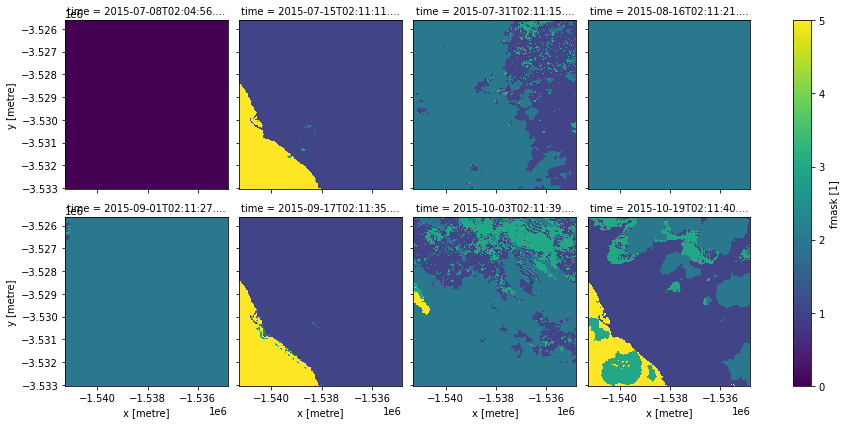

In [6]:
data.fmask.plot(col="time", col_wrap=4)

We see that `fmask` also reports the `nodata` pixels, and along with the cloud and shadow pixels, it picked up the ocean as water too.

## Cloud-free images

### Creating the clear-pixel mask

We create a mask by specifying conditions that our pixels must satisfy.
But we will only need the labels (e.g. `fmask="valid"`) to create a mask.

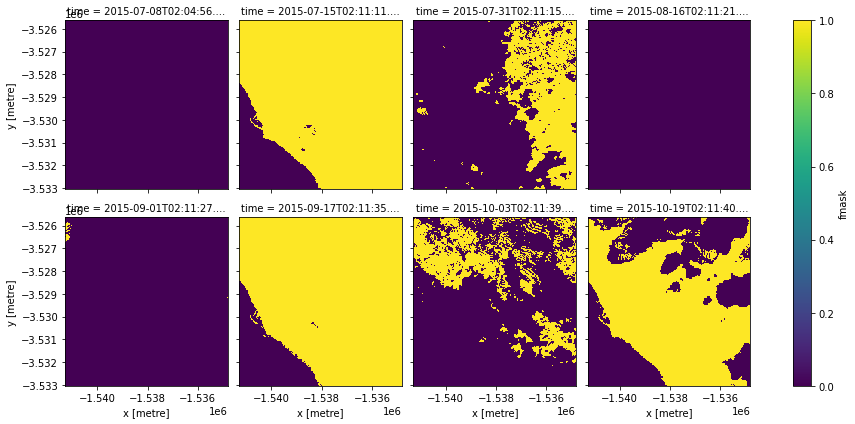

In [7]:
# Create the mask based on "valid" pixels
clear_mask = make_mask(data.fmask, fmask="valid")
clear_mask.plot(col="time", col_wrap=4)

### Applying the clear-pixel mask
We can now get the clear images we want.

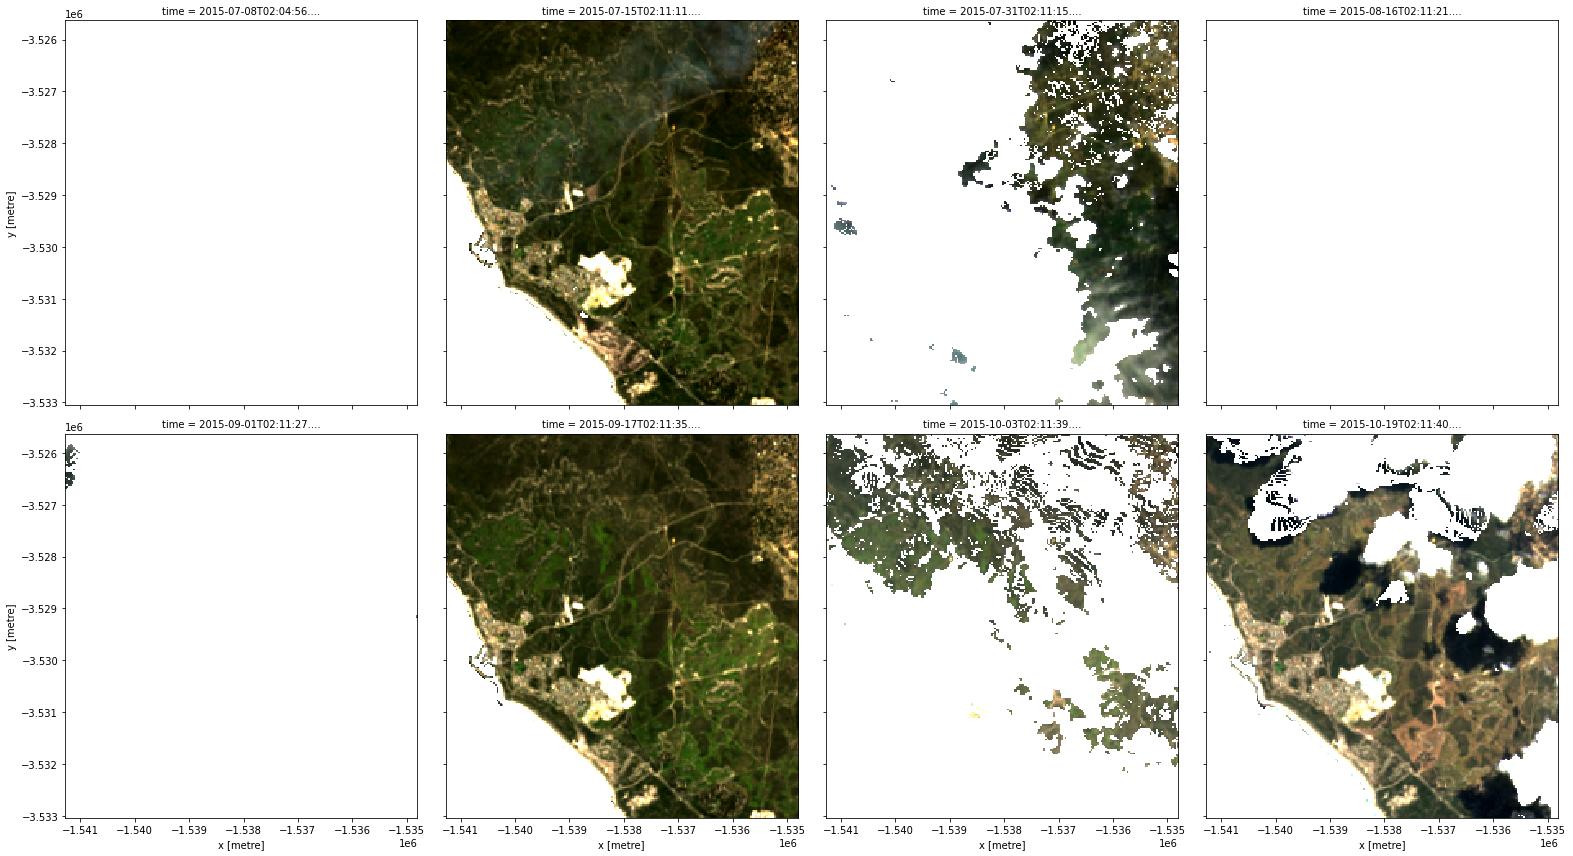

In [8]:
# Apply the mask
clear = data.where(clear_mask)
rgb(clear, col="time")

### Cloud-free images

If we look carefully, we can see that we have lost the ocean too.
Sometimes we may instead want to create a mask using a combination of different `fmask` features.
For example, below we create a mask that will preserve pixels that are flagged as either valid, water or snow (and mask out any cloud or cloud shadow pixels):

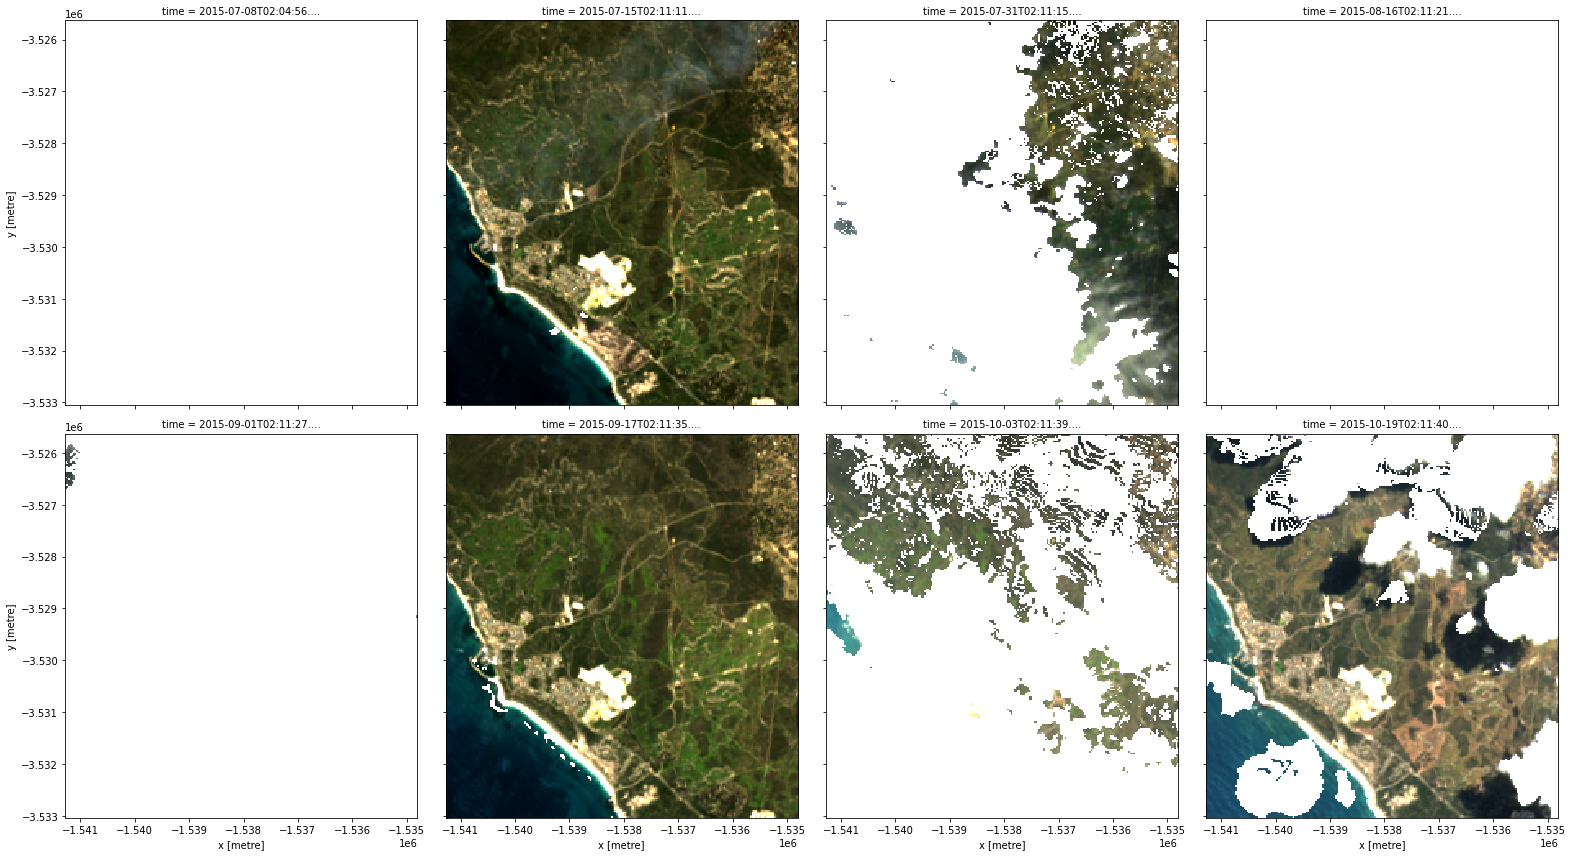

In [9]:
# Identify pixels that are either "valid", "water" or "snow"
cloud_free_mask = (
    make_mask(data.fmask, fmask="valid") | 
    make_mask(data.fmask, fmask="water") | 
    make_mask(data.fmask, fmask="snow")
)

# Apply the mask
cloud_free = data.where(cloud_free_mask)
rgb(cloud_free, col="time")

## Mask dilation and cleaning

Sometimes we want our cloud masks to be more conservative and mask out more than just the pixels that `fmask` classified as cloud or cloud shadow.
That is, sometimes we want a buffer around the cloud and the shadow. We can achieve this by dilating the mask using the `mask_cleanup` function from `odc.algo`.

Because we now want to focus on cloud and cloud shadow pixels, we first do the opposite to our previous examples and create a mask which has `True` values if a pixel contains either cloud or cloud shadow, and `False` for all others (e.g. valid, snow, water).
When we plot this data, cloud and cloud shadow will appear as yellow, and other pixels as purple.

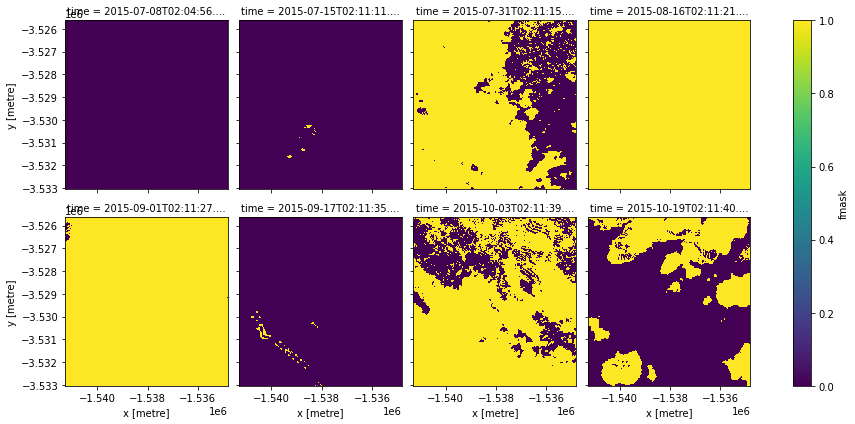

In [10]:
# Identify pixels that are either "cloud" or "cloud_shadow"
cloud_shadow_mask = (
    make_mask(data.fmask, fmask="cloud") | 
    make_mask(data.fmask, fmask="shadow")
)

# Plot
cloud_shadow_mask.plot(col="time", col_wrap=4)

We now apply `mask_cleanup`. 
This function allows us to modify areas of cloud and cloud shadow using image processing techniques called [morphological operations](https://scikit-image.org/docs/dev/auto_examples/applications/plot_morphology.html#sphx-glr-auto-examples-applications-plot-morphology-py). 
These tools can be used to expand and contract regions of our image to change the shape of specific features - in this case, clouds and cloud shadow. 
Four of the most useful morphological techniques include:

* **Dilation:** Expand (i.e. "dilate") `True` values outward, resulting in larger `True` features
* **Erosion:** Shrink (i.e. "erode") `True` values inward, resulting in smaller `True` features
* **Closing:** First dilate, then erode `True` pixels. This is used to fill small or narrow `False` gaps inside or between `True` features.
* **Opening:** First erode, then dilate `True` pixels. This is used to remove small or narrow areas of `True` features, but preserve larger features.

All of these operations are applied using a specific radius to control how many pixels our clouds and shadows are dilated, eroded, closed or opened. 
For example, we can specify that our clouds and shadows are expanded by 5 pixels in all directions as follows:

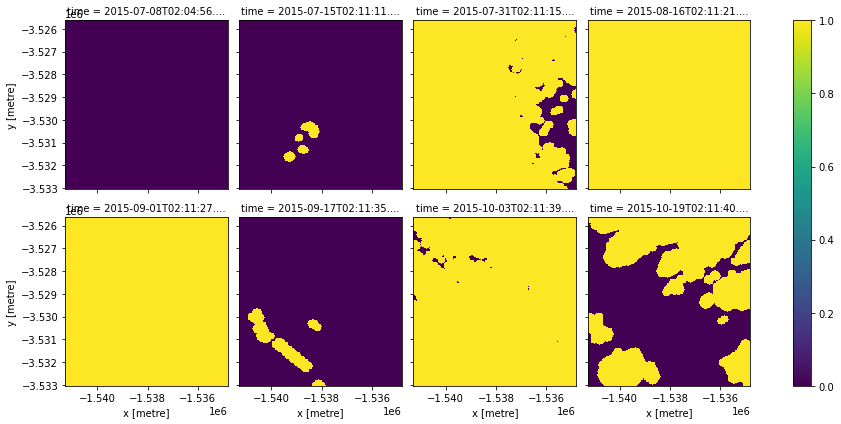

In [11]:
# Dilate all cloud and cloud shadow pixels by 5 pixels in all directions
cloud_shadow_buffered = mask_cleanup(mask=cloud_shadow_mask,
                                     mask_filters=[("dilation", 5)])
cloud_shadow_buffered.plot(col="time", col_wrap=4)

Our clouds and shadows (yellow) have now been expanded outwards (compare this to the `cloud_shadow_mask` data we plotted earlier).

We can now apply this dilated cloud and shadow mask to our original data (note we need to reverse our mask using `~` so that valid pixels are marked with `True` as in our original un-dilated example).

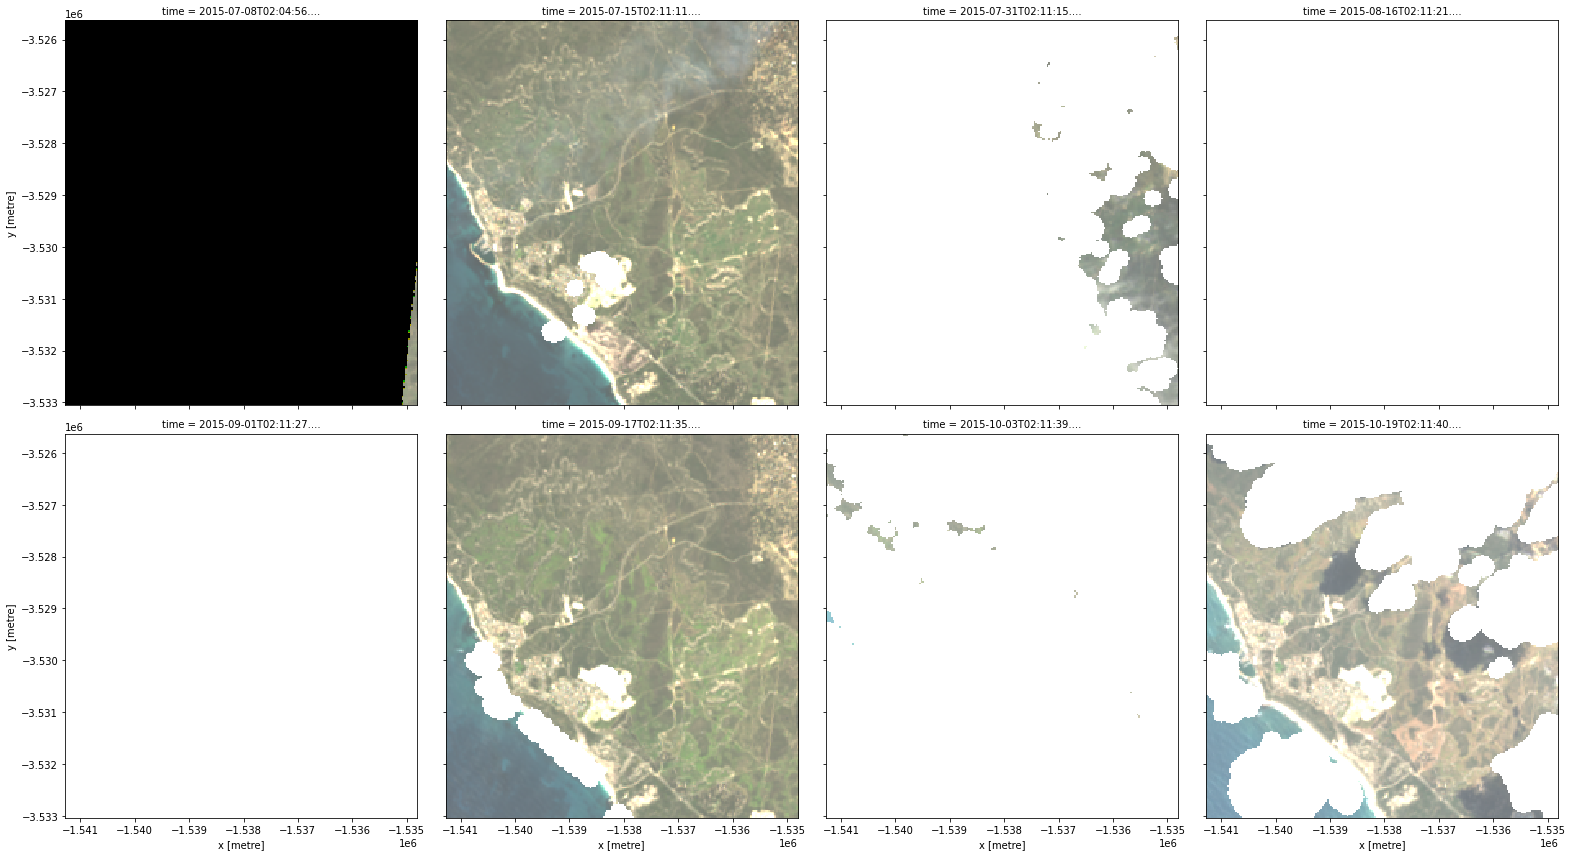

In [12]:
# Apply the mask
buffered_cloud_free = data.where(~cloud_shadow_buffered)
rgb(buffered_cloud_free, col="time")

Cloud mask data from `fmask` can commonly include false positive clouds over features including urban areas, bright sandy beaches and salt pans. 
We can see an example of this in the sixth panel, where a length of beach has been erroneously mapped as cloud.

To reduce these false positives, it can often be useful to apply a morphological "opening" operation before we dilate our clouds and shadows.
This operation can remove small or narrow clouds by first "shrinking" then "expanding" our cloud and shadow pixels. 
To apply an opening operation with a radius of 3, we can supply an extra `("opening", 3)` processing step using `mask_cleanup`:

In [13]:
# Dilate all cloud and cloud shadow pixels by 5 pixels in all directions
cloud_shadow_buffered = mask_cleanup(mask=cloud_shadow_mask,
                                     mask_filters=[("opening", 3), ("dilation", 5)])

# Apply the mask
buffered_cloud_free = data.where(~cloud_shadow_buffered)

Now when we plot our data, we can see that the sixth panel is no longer affected by false positive clouds along the bright narrow beach.

> **Note:** Morphological operations and radiuses are application-specific; make sure to experiment with a range of options to make sure they have the effect you are looking for.

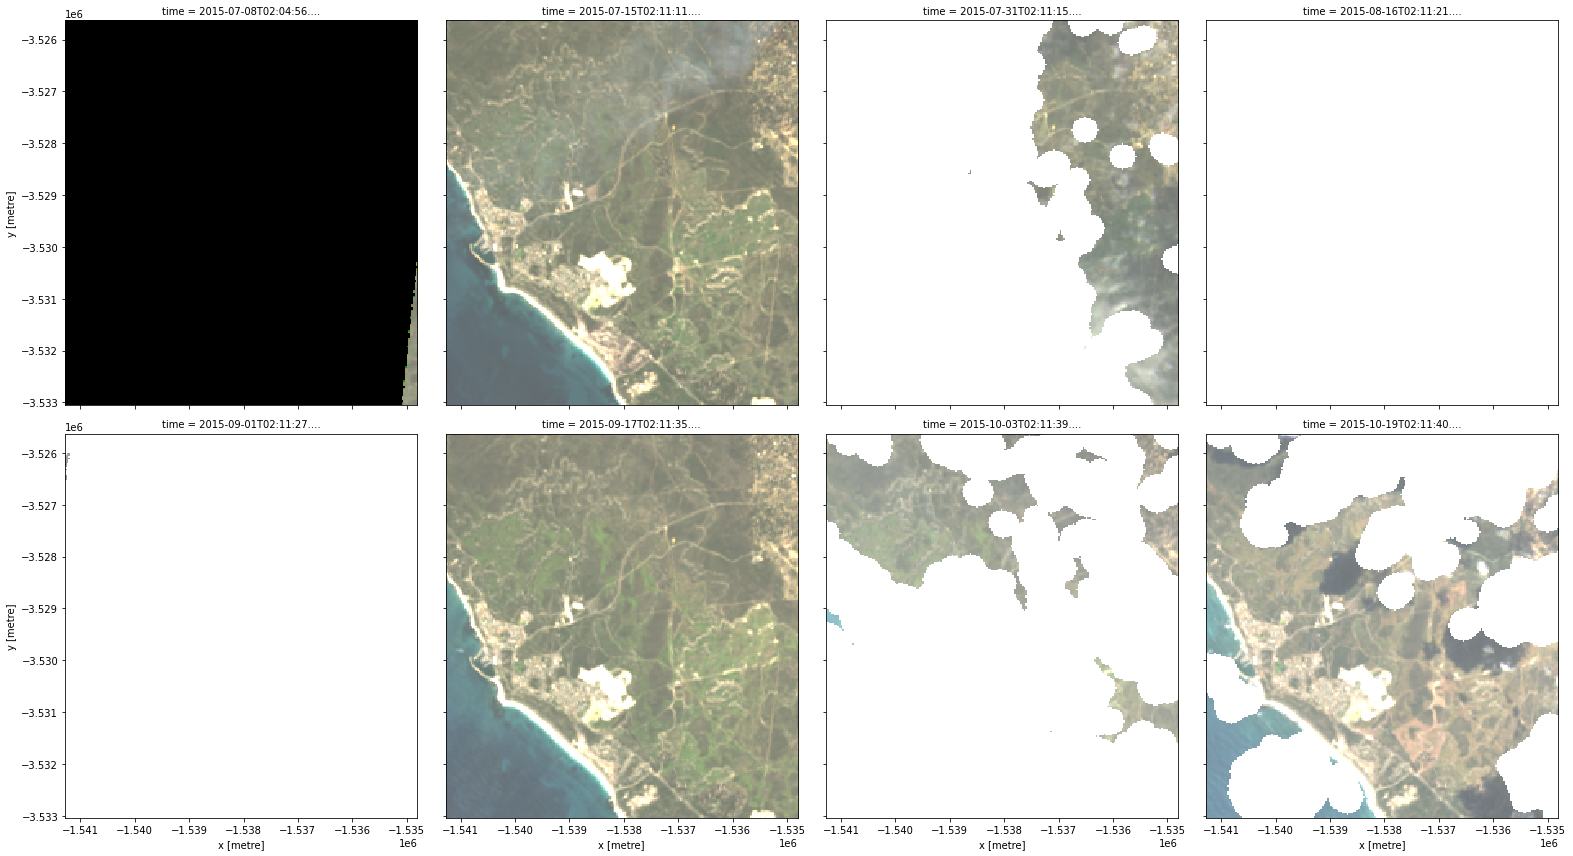

In [14]:
rgb(buffered_cloud_free, col="time")

## Masking out invalid data



Finally, we need to set all pixels containing `-999` nodata values to `nan` so that they do not affect subsequent analyses.
This can be performed automatically using the `mask_invalid_data` function:

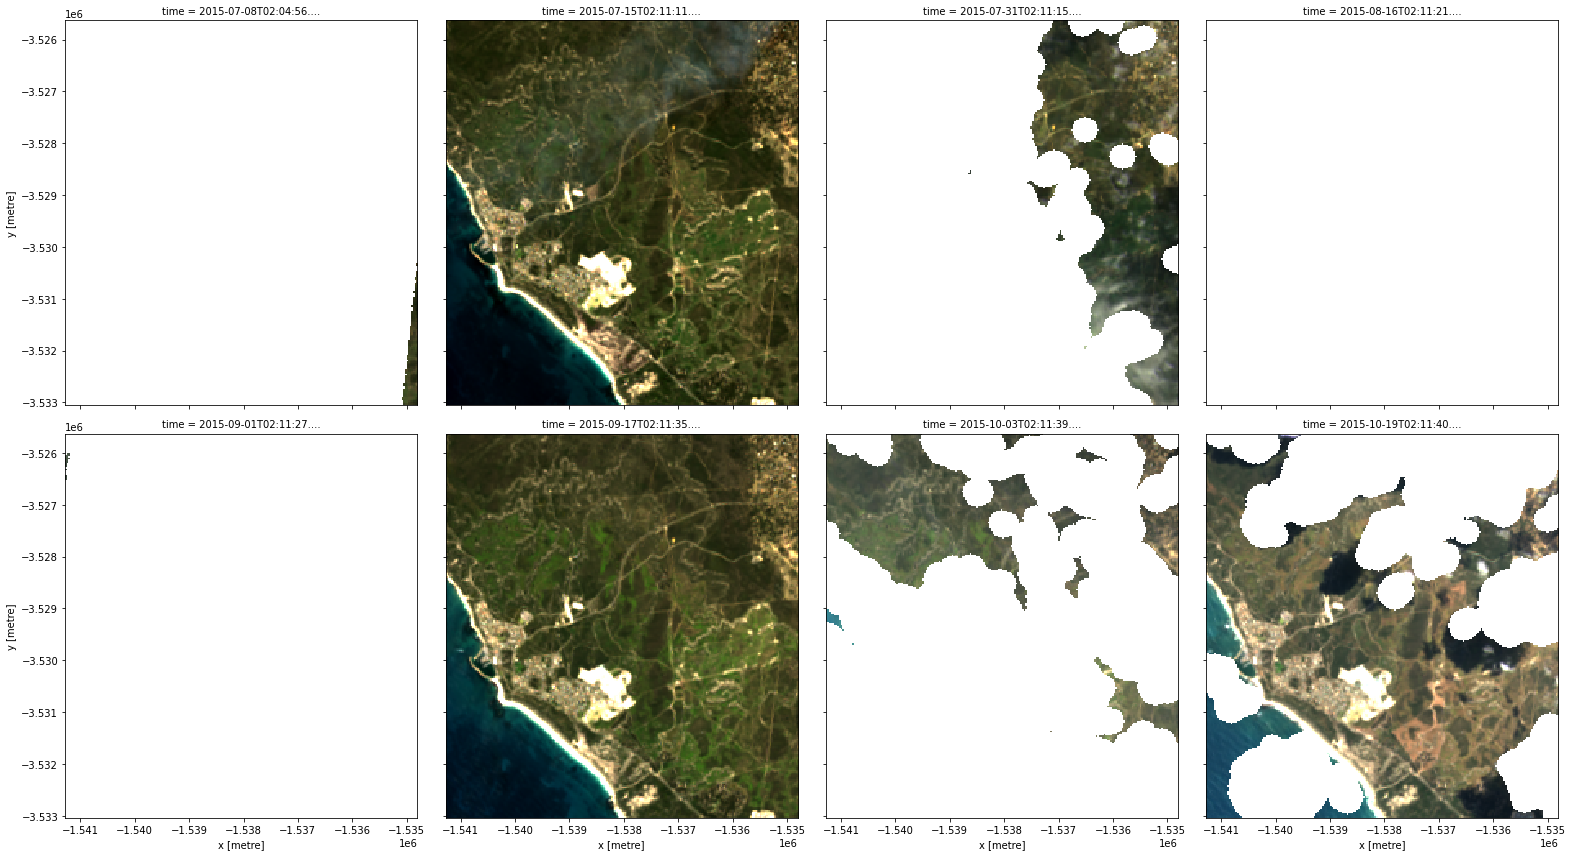

In [15]:
# Set invalid nodata pixels to NaN
valid_data = mask_invalid_data(buffered_cloud_free)
rgb(valid_data, col='time')

When we inspect our data, we can see that all `-999` values have now been replaced with `nan`:

In [16]:
valid_data.nbart_red.isel(time=0)

<xarray.DataArray 'nbart_red' (y: 247, x: 216)>
array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ...,
       [ nan,  nan,  nan, ..., 430., 420., 393.],
       [ nan,  nan,  nan, ..., 396., 388., 378.],
       [ nan,  nan,  nan, ..., 442., 396., 376.]])
Coordinates:
    time         datetime64[ns] 2015-07-08T02:04:56.777964
  * y            (y) float64 -3.526e+06 -3.526e+06 ... -3.533e+06 -3.533e+06
  * x            (x) float64 -1.541e+06 -1.541e+06 ... -1.535e+06 -1.535e+06
    spatial_ref  int32 3577
Attributes:
    units:         1
    nodata:        -999
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Discord chat](https://discord.com/invite/4hhBQVas5U) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [GitHub](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** December 2023

**Compatible datacube version:** 

In [17]:
print(datacube.__version__)

1.8.6


## Tags
<!-- Browse all available tags on the DEA User Guide's [Tags Index](https://knowledge.dea.ga.gov.au/genindex/) -->